In [62]:
import pandas as pd

# Read the Excel file
excel_file = r'../data/weather_data.xlsx'
df = pd.read_excel(excel_file)

# Convert to CSV
csv_file = r'../data/weather_data.csv'
df.to_csv(csv_file, index=False)


<Axes: >

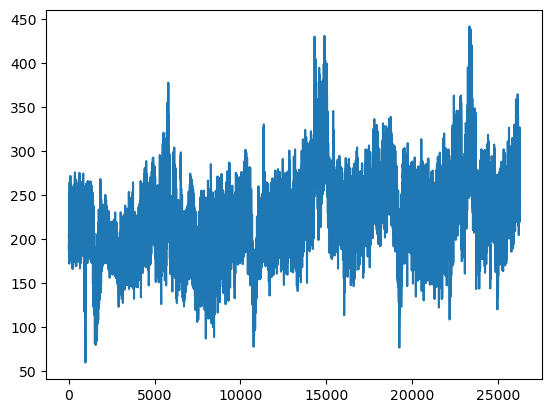

In [84]:
df['load'].plot()


# 指标方案

In [66]:
import pandas as pd
###方案一：直接统计法 ：标识震荡的幅度，为1时表示单调，越小震荡越大？
def direct_statistic(df:pd.DataFrame) -> float:
    seqLength=len(df)
    S=0
    for i in range(1,seqLength):
        S +=abs(df.iloc[i,0]-df.iloc[i-1,0])
    return abs(df.iloc[seqLength-1,0]-df.iloc[0,0]) / S 


0.008394645980570088

In [67]:
###方案二：斜率法（numpy的polyfit：用一个多项式去拟合时间序列变化，若是一次幂，取倒数的第二个系数即为斜率k，y=kx+c）
#正数：上升趋势，负数：下降趋势，0：平稳
import numpy as np
def trendline(index: list, data: pd.DataFrame, order: int = 1) -> float:
    lst=data[data.columns[0]].tolist() #将dataframe第一列转换为一维list
    coeffs = np.polyfit(index, list(lst), order)
    slope = coeffs[-2]
    return slope

resultent = trendline(df_Temperature.index, df_Temperature)
print(resultent)

-0.000637222781488655


In [68]:
#方案三：Cox-Stuart趋势检验
#最后就返回p_value把，小于0.05就是显著的，可以判断上升或者下降，大于0.05就是不显著的，默认判断为无趋势
import scipy.stats as stats


def cos_staut(data:pd.DataFrame, debug=False) -> str:
    lst=data[data.columns[0]].tolist()
    raw_len = len(lst)
    if raw_len % 2 == 1:
        del lst[int((raw_len - 1) / 2)]
    c = int(len(lst) / 2)
    n_pos = n_neg = 0
    for i in range(c):
        diff = lst[i + c] - lst[i]
        if diff > 0:
            n_pos += 1
        elif diff < 0:
            n_neg += 1
        else:
            continue
    num = n_pos + n_neg
    k = min(n_pos, n_neg)
    p_value = 2 * stats.binom.cdf(k, num, 0.5)
    if debug:
        print("fall:%i, rise:%i, p-value:%f" % (n_neg, n_pos, p_value))
    #print(n_pos)
    if n_pos > n_neg and p_value < 0.05:
        return "increasing"
    elif n_neg > n_pos and p_value < 0.05:
        return "decreasing"
    else:
        return "no trend"


'no trend'

In [69]:
import math
from scipy.stats import mstats, norm
#方案四：MK趋势检验
#MK检验：不要求数据服从正态分布，但是要求数据是独立的
#最后就返回p_value把，小于0.05就是显著的，可以判断上升或者下降，大于0.05就是不显著的，默认判断为无趋势
def mk_test(data:pd.DataFrame, alpha=0.05) -> str:
    x=data[data.columns[0]].tolist()
    n = len(x)

    # calculate S
    s = 0
    for k in range(n - 1):
        for j in range(k + 1, n):
            s += np.sign(x[j] - x[k])

    # calculate the unique data
    unique_x, tp = np.unique(x, return_counts=True)
    g = len(unique_x)

    # calculate the var(s)
    if n == g:  # there is no tie
        var_s = (n * (n - 1) * (2 * n + 5)) / 18
    else:  # there are some ties in data
        var_s = (n * (n - 1) * (2 * n + 5) - np.sum(tp * (tp - 1) * (2 * tp + 5))) / 18

    if s > 0:
        z = (s - 1) / np.sqrt(var_s)
    elif s < 0:
        z = (s + 1) / np.sqrt(var_s)
    else:  # s == 0:
        z = 0

    # calculate the p_value
    p = 2 * (1 - norm.cdf(abs(z)))  # two tail test
    h = abs(z) > norm.ppf(1 - alpha / 2)

    if (z < 0) and h:
        trend = "decreasing"
    elif (z > 0) and h:
        trend = "increasing"
    else:
        trend = "no trend"
    #print(p, h)
    return trend

'decreasing'

# one-hot编码示例

In [70]:
import pandas as pd

# 创建一个包含颜色和尺寸的 DataFrame
df = pd.DataFrame({
  'color': ['red', 'blue', 'green', 'red', 'blue'],
  'size': [5, 6, 7, 5, 6]
})
df['color'] = df['color'].astype(str)
# 使用 get_dummies 函数进行 One-hot 编码
df_encoded = pd.get_dummies(df, columns=['color'])
df_encoded = df_encoded.astype(int) #将原来的bool类型转换为int
df_encoded

,size,color_blue,color_green,color_red
0,5,0,0,1
1,6,1,0,0
2,7,0,1,0
3,5,0,0,1
4,6,1,0,0


## 数据预处理

In [85]:
import pandas as pd
from scipy import stats

df=pd.read_csv('../data/data.csv')
k2, p = stats.normaltest(df['load']) #原假设H0：符合正态分布
alpha = 0.05
if p < alpha:  # null hypothesis: x comes from a normal distribution
    print("拒绝样本是正态分布的假设")
else:
    print("不能拒绝正态分布的假设")


拒绝样本是正态分布的假设


In [80]:
#选取每一天24个时刻的数据，并进行四个指标运算，得到四个结果列表，然后将最终结果存入一个新的dataframe中
ConcussionShake,Slope,CoxStuart,Mk=[],[],[],[]
for i in range(0,len(df)-24+1,24):
    load=df[['load']][i:i+24]
    #方案一：直接统计法 ：标识震荡的幅度，为1时表示单调，越小震荡越大越不规律
    ConcussionShake.append(direct_statistic(load))
    #方案二：斜率法 #正数：上升趋势，负数：下降趋势，0：平稳
    Slope.append(trendline(load.index, load))
    #方案三：Cox-Stuart趋势检验（要正态分布） #p_value小于0.05就是显著的，可以判断上升或者下降，大于0.05就是不显著的，默认判断为无趋势
    CoxStuart.append(cos_staut(load))
    #方案四：MK趋势检验 #不要求数据服从正态分布，但是要求数据是独立的
    Mk.append(mk_test(load))


In [87]:
while(True):  
    try:
        time = input('请输入想要预测的时间是每天几点(24h制)？：')
        time = int(time)
        if time < 0 or time > 23:
            print("输入范围应为：0~23")
            continue
        break
    except ValueError:
        print("输入范围应为：0~23")

df_new=df.iloc[time::24, :].copy() #第一个冒号省略是到剩下所有行，后面的冒号是取所有列
df_new.loc[:, 'ConcussionShake'] = ConcussionShake
df_new.loc[:, 'Slope'] = Slope
df_new.loc[:, 'CoxStuart'] = CoxStuart
df_new.loc[:, 'Mk'] = Mk
df_new.head(10)

,date,load,year,month,hour,day,lowtmep,hightemp,ConcussionShake,Slope,CoxStuart,Mk
8,2016/11/25 8:00,228.001,0.0,0.909091,0.347826,0.666667,0.302326,0.243902,0.087683,0.791108,no trend,no trend
32,2016/11/26 8:00,224.432,0.0,0.909091,0.347826,0.833333,0.325581,0.243902,0.065419,1.819420,no trend,increasing
56,2016/11/27 8:00,223.996,0.0,0.909091,0.347826,1.000000,0.325581,0.219512,0.148006,0.690724,no trend,no trend
80,2016/11/28 8:00,235.431,0.0,0.909091,0.347826,0.000000,0.302326,0.219512,0.030532,1.574692,no trend,increasing
104,2016/11/29 8:00,237.024,0.0,0.909091,0.347826,0.166667,0.325581,0.317073,0.173919,0.581039,no trend,no trend
128,2016/11/30 8:00,228.732,0.0,0.909091,0.347826,0.333333,0.395349,0.292683,0.082343,1.165819,no trend,no trend
152,2016/12/1 8:00,245.874,0.0,1.000000,0.347826,0.500000,0.325581,0.243902,0.121605,0.686315,no trend,no trend
176,2016/12/2 8:00,222.980,0.0,1.000000,0.347826,0.666667,0.418605,0.341463,0.211474,-0.612688,no trend,no trend
200,2016/12/3 8:00,212.482,0.0,1.000000,0.347826,0.833333,0.418605,0.439024,0.131192,0.017598,no trend,no trend
224,2016/12/4 8:00,204.528,0.0,1.000000,0.347826,1.000000,0.441860,0.317073,0.039815,1.309493,no trend,increasing


In [90]:
len(df_new)

1095